# Sudoku Solver


We consider the $n=2$ case of a Sudoku puzzle. The input is a $4\times 4$ array of integers from 0 to 4, with 0 denoting the empty cells. The output is the solved puzzle, along with the probability that the solution is correct.

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator

import numpy as np

## From puzzle to empty quantum circuit
In this section we define the functions to create our oracle. The first function creates an empty quantum circuit corresponding to the original puzzle. This function currently accepts any size list of lists. 

### To add
- An input checker to confirm that the user's lists are a valid square puzzle of the specified puzzle size.
- The puzzle size is currently hardcoded for $n=2$, but I have tried to write the majority of the code in such a way that it will extend automatically. Where there are manual changes needed, it is noted in the comments.

In [80]:
puzzle_size = 2
def build_sudoku_circuit(puzzle: list[list[int]]): #input puzzle as a list of lists 
    empty_cells = [] # a list of the "empty" cells from the original puzzle by row and column
    for row in range(puzzle_size**2):
        for column in range(puzzle_size**2):
            if puzzle[row][column] == 0:
                empty_cells.append((row,column))
    empty_cell_registers = { } # an dictionary mapping to a 2 qubit register for each empty cell
    for (row,column) in empty_cells:
        reg_name = f"r{row}_c{column}"
        qr = QuantumRegister(2, name=reg_name) # This size needs to be adjusted for a generic puzzle
        empty_cell_registers [(row, column)] = qr
    ancillary_calcbits = QuantumRegister(3, name = "calc") # This size needs to be adjusted for a generic puzzle. 
    ancillary_row = QuantumRegister(puzzle_size**2, name = "arow") # 4 ancillary qubits to check rows
    ancillary_col = QuantumRegister(puzzle_size**2, name = "acol") # 4 ancillary qubits to check columns
    ancillary_sq = QuantumRegister(puzzle_size**2, name = "asq") # 4 ancillary qubits to check squares
    allregisters =  list(empty_cell_registers.values()) + [ancillary_row,ancillary_col,ancillary_sq] + [ancillary_calcbits] 
    qc = QuantumCircuit(*allregisters, name="Sudoku_Circuit")
    
    return qc, empty_cell_registers, ancillary_calcbits, ancillary_row, ancillary_col, ancillary_sq
# Function returns the quantum circuit and all of the associated registers



### Example use of function with test puzzle

    [1, 0, 0, 4],
    [3, 0, 1, 0],
    [0, 1, 0, 3],
    [4, 0, 2, 1]

In [94]:
test_puzzle = [[1, 0, 0, 4], [3, 0, 1, 0],[0, 1, 0, 3],[4, 0, 2, 1]]
sudoku_qc_test = build_sudoku_circuit(test_puzzle)
sudoku_qc_test

(<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x10f35cc90>,
 {(0, 1): QuantumRegister(2, 'r0_c1'),
  (0, 2): QuantumRegister(2, 'r0_c2'),
  (1, 1): QuantumRegister(2, 'r1_c1'),
  (1, 3): QuantumRegister(2, 'r1_c3'),
  (2, 0): QuantumRegister(2, 'r2_c0'),
  (2, 2): QuantumRegister(2, 'r2_c2'),
  (3, 1): QuantumRegister(2, 'r3_c1')},
 QuantumRegister(3, 'calc'),
 QuantumRegister(4, 'arow'),
 QuantumRegister(4, 'acol'),
 QuantumRegister(4, 'asq'))

## Oracle helper functions

Our oracle will check each row column and square to determine whether there are conflicts. If there are no conflicts, the associated ancillary bit will be set to 1. The calculation will use two scratch qubits. 

In [90]:
#The oracle needs to know what the puzzle is! These functions should work for an arbitrary size puzzle.

def puzzle_constraints(puzzle: list[list[int]]):
    constraints = {}
    for i in range(len(puzzle)):
        constraints.update({f"row{i}" : [puzzle[i][j] for j in range(len(puzzle)) if puzzle[i][j]!=0]}) #parsing the row values
        constraints.update({f"col{i}" : [puzzle[j][i] for j in range(len(puzzle)) if puzzle[j][i]!=0]}) #parsing the column values
    for i in range(puzzle_size):
        for j in range(puzzle_size): #parsing the square values
            square_list=[]
            for a in range(puzzle_size):
                for b in range(puzzle_size):
                    if puzzle[puzzle_size*i+a][puzzle_size*j+b]!=0:
                        square_list.append(puzzle[puzzle_size*i+a][puzzle_size*j+b])
            constraints.update({f"square{i}{j}" : square_list}) #parsing the square values

    return constraints


In [83]:
# test the constraint function with the test puzzle
puzzle_info = puzzle_constraints(test_puzzle)
puzzle_info

{'row0': [1, 4],
 'col0': [1, 3, 4],
 'row1': [3, 1],
 'col1': [1],
 'row2': [1, 3],
 'col2': [1, 2],
 'row3': [4, 2, 1],
 'col3': [4, 3, 1],
 'square00': [1, 3],
 'square01': [4, 1],
 'square10': [1, 4],
 'square11': [3, 2, 1]}

### Here is the test puzzle again to compare:

    [1, 0, 0, 4],
    [3, 0, 1, 0],
    [0, 1, 0, 3],
    [4, 0, 2, 1]

### Some helper gates

In this little section, we are setting up the gates that will detect conflicts with the given puzzle. We want a reversible circuit that will detect whether two qubits in the row corresponding to empty cells encode the same value or any of the empty cell qubits encode a value given as a constant of the puzzle. We will record a +1 in the ancillary bit corresponding to that row if and only if there are no conflicts. 

The first step to build this circuit is a comparison gate between two registers, each corresponding to an unknow value in the puzzle.

In [ ]:
#Comparison circuit that flips a conflict bit to 1 if two registers, A and B, are equal. We will use this as a gate in our oracle.

qr_A = QuantumRegister(2, "a")
qr_B = QuantumRegister(2, "b")
tmp = QuantumRegister(2,"t")
conflict = QuantumRegister(1,"cf")

compare_qubits_circuit = QuantumCircuit(qr_A,qr_B,tmp,conflict, name = "Compare Qubits")
compare_qubits_circuit.cx(qr_A[0],tmp[0]) # These four CX gates compute an XOR of the two registers in the tmp register
compare_qubits_circuit.cx(qr_A[1],tmp[1])
compare_qubits_circuit.cx(qr_B[0],tmp[0])
compare_qubits_circuit.cx(qr_B[1],tmp[1])
compare_qubits_circuit.x(tmp[0]) # These two X gates flip the tmp bits to be both 1 if and only if the two registers agree. 
compare_qubits_circuit.x(tmp[1])
compare_qubits_circuit.ccx(tmp[0],tmp[1],conflict[0]) # The conflict bit is set to 1 if and only if the two registers agree.
# Now we reset the tmp bits to 0 the order doesn't matter for these operators, but we'll put it in reverse for good measure.
compare_qubits_circuit.x(tmp[1])
compare_qubits_circuit.x(tmp[0])
compare_qubits_circuit.cx(qr_B[1],tmp[1])
compare_qubits_circuit.cx(qr_B[0],tmp[0])
compare_qubits_circuit.cx(qr_A[1],tmp[1])
compare_qubits_circuit.cx(qr_A[0],tmp[0])



CompReg = compare_qubits_circuit.to_gate()





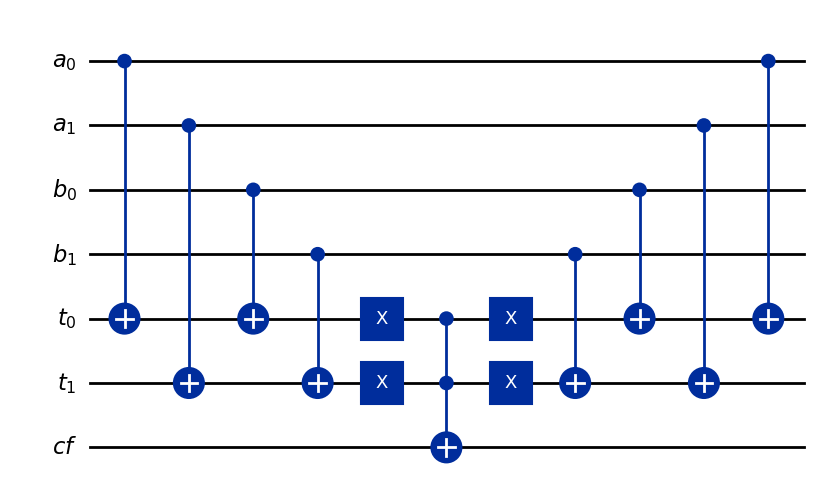

In [93]:
compare_qubits_circuit.draw("mpl")

## Recording found conflicts
The next gate that I will construct will set the region conflict bit to zero if a conflict is found. Once this bit is set to zero, it remains zero until the application of the multi-controlled Z-gate used to mark the solution. Note that the cell-conflict marker is also returned to zero at the end of the execution of this circuit, but the additional bookkeeping bits (0 and 1) are not controlled.

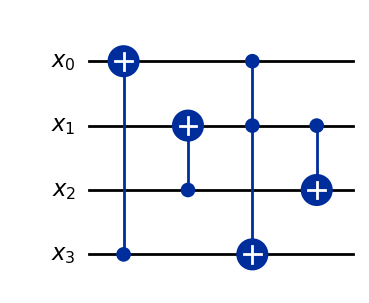

In [103]:
bookkeeping_register = AncillaRegister(4, name = "x")
#the top two registers are for bookkeeping and are assumed to be zero at the start of the circuit. 
bookkeeping_circuit = QuantumCircuit(bookkeeping_register, name = "Record Conflict")
bookkeeping_circuit.cx(bookkeeping_register[3],bookkeeping_register[0]) #copy area conflict record to temp register 0
bookkeeping_circuit.cx(bookkeeping_register[2],bookkeeping_register[1]) #copy cell conflict to temp register 1
bookkeeping_circuit.ccx(bookkeeping_register[0],bookkeeping_register[1],bookkeeping_register[3]) #conflict record to zero if new conflict
bookkeeping_circuit.cx(bookkeeping_register[1],bookkeeping_register[2]) #set cell conflict to zero
bookkeeping_circuit.draw("mpl")

In [104]:
RecordCF = bookkeeping_circuit.to_gate()

## Specializing to example circuit
I am completing this code for the example circuit above. I have tried to use labels so that I automate the gate construction from the puzzle parsing above and apply the working code to any 4x4 puzzle, but that will be relegated to the next "upgrade".

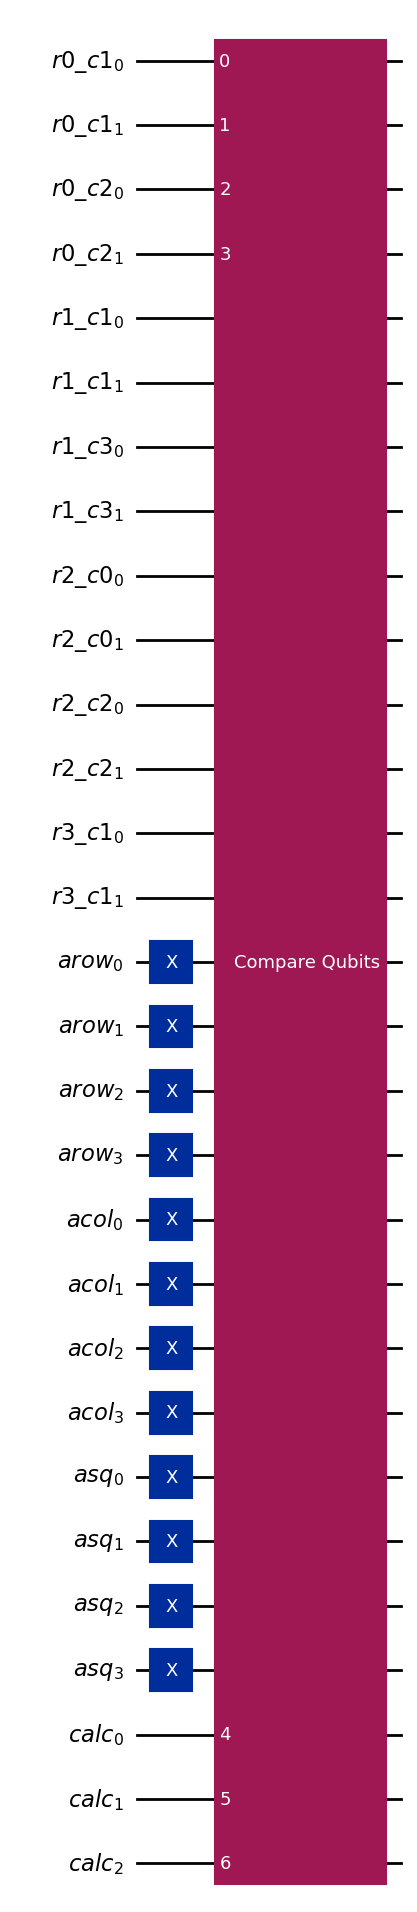

In [ ]:
#Try adding this gate to our circuit

quantum_circuit = sudoku_qc_test[0]
quantum_regs = sudoku_qc_test[1] #We give names to the wires in our circuit. This is the quantum register dictionary
calcbits = sudoku_qc_test[2] #Temporary calculation bits (3)
rowbits = sudoku_qc_test[3] #Conflict tracking bits for rows 0-3
colbits = sudoku_qc_test[4] #Conflict tracking bits for columns 0-3
sqbits = sudoku_qc_test[5]  ##Conflict tracking bits squares numbered 0=00, 1=01 2=10, 3=11
quantum_circuit.x([*rowbits,*colbits,*sqbits]) #set all conflict qubits for rows, columns and squares to 1
quantum_circuit.compose(CompReg, qubits = [quantum_regs[(0,1)][0],quantum_regs[(0,1)][1],quantum_regs[(0,2)][0],quantum_regs[(0,2)][1],calcbits[0],calcbits[1],calcbits[2]],inplace = "True")
#This compares the two qubits in the first row
quantum_circuit.draw("mpl")

## Recording the conflict   

We add a gate that will be the identity unless it is the first conflict for that ancilla's region.

## Grover's Search Algorithm
Now that we have marked the solution, we can apply Grover's algorithm to find it! We first construct the diffusion gate. Note that the number of times that we must repeat our diffusion gate will depend on the number of empty cells in the puzzle, so we calculate that next. Finally we construct the full circuit and apply it to our test puzzle.